In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import pickle
import joblib
import contextlib
from tqdm import tqdm
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
# Parallel Job Progress Bar

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object

    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
# define U and its gradient wrt theta

def U_NN(theta, x, **kwargs):
    w, b = theta[:-1], theta[-1]
    z, y = x[:,:-1], x[:,-1]
    ip_NN = np.dot(z, w) + b
    return np.abs(y - 1 / (1 + np.exp(-ip_NN)))**2

def grad_U_NN(theta, x, **kwargs):
    w, b = theta[:-1], theta[-1]
    z, y = x[:,:-1], x[:,-1]
    ip_NN = np.dot(z, w) + b
    sigmoid_op = 1 / (1 + np.exp(-ip_NN))
    error = y - sigmoid_op
    
    der_w = -2 * error[:, np.newaxis] * z * sigmoid_op[:, np.newaxis] * (1 - sigmoid_op[:, np.newaxis])
    der_b = -2 * error * sigmoid_op * (1 - sigmoid_op)
    
    grad = np.zeros((x.shape[0], theta.shape[0]))
    grad[:, :-1] = der_w
    grad[:, -1] = der_b
    return grad

In [4]:
# Discretisation of Compact Support

def set_prod(*arr_lst):
    n_arrs = len(arr_lst)
    datatype = np.result_type(*arr_lst)
    arr = np.empty([len(a) for a in arr_lst] + [n_arrs], dtype=datatype)
    for i, a in enumerate(np.ix_(*arr_lst)):
        arr[..., i] = a
    return arr.reshape(-1, n_arrs)



ell = 3
j = 1

# uniform distribution
xi_range = [-3, 3]

# discretised space
dyadic_set = np.arange(-2**(ell-1), 2**(ell-1), 1/2**j) # dyadic
dyadic_set = dyadic_set[np.logical_and(dyadic_set >= xi_range[0], dyadic_set <= xi_range[1])]
dyadic_set

# m = dimension of data
m = 4

discrete_space = set_prod(*[dyadic_set]*m)

In [5]:
# (Robust) SGLD
def iota(alpha):
    return np.log(np.cosh(alpha))

def grad_iota(alpha):
    return np.tanh(alpha)

# returns vector; evaluated at all points of discretised space
def F_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs):
    theta, alpha = theta_bar[:-1], theta_bar[-1]
    return np.exp(
        (U(theta, discrete_space, **kwargs)-iota(alpha)*np.linalg.norm(x-discrete_space, axis=1)**p)/delta
    )

def grad_V_delta(theta_bar, x, delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs):
    theta, alpha = theta_bar[:-1], theta_bar[-1]
    F = F_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs)
    grad_V = np.zeros(theta_bar.shape[0])
    
    grad_V[:-1] = eta1*theta + np.dot(F, grad_U(theta, discrete_space, **kwargs))/np.sum(F)
    grad_V[-1] = (
        eta2*iota(alpha)*grad_iota(alpha)-
        grad_iota(alpha)*np.dot(F, np.linalg.norm(x-discrete_space, axis=1)**p)/np.sum(F)
    )
    
    return grad_V

def V_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs):
    F = F_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs)
    N = discrete_space.shape[0]
    avg_exp_term = np.sum(F) / N
    return delta * np.log(avg_exp_term)

def tilde_V_delta(theta_bar, x, delta, eta1, eta2, p, U, iota, discrete_space, **kwargs):
    V_val = V_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs)
    theta, alpha = theta_bar[:-1], theta_bar[-1]
    regularization_theta = (eta1 / 2) * np.linalg.norm(theta)**2
    regularization_alpha = (eta2 / 2) * np.linalg.norm(iota(alpha))**2   
    return V_val + regularization_theta + regularization_alpha

def v_delta(theta_bar, x_data, delta, eta1, eta2, p, U, iota, discrete_space, **kwargs):
    # Initialize an array to store the tilde_V_val for each x
    tilde_V_vals = np.zeros(x_data.shape[0])
    
    # Iterate over each x in discrete_space and compute tilde_V_val
    for idx, x in enumerate(x_data):
        tilde_V_vals[idx] = tilde_V_delta(theta_bar, x, delta, eta1, eta2, p, U, iota, discrete_space, **kwargs)
    
    # Compute the mean of all tilde_V_vals
    empirical_mean = np.mean(tilde_V_vals)
    
    return empirical_mean

In [6]:
def robust_sgld(n_iter, step, beta, 
                theta_bar_0, x_data, delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs):
    
    # initialise algorithm
    theta_bar = theta_bar_0
    
    # Store theta_bar for each iteration
    theta_bar_history = np.zeros((n_iter, theta_bar_0.shape[0]))
    
    # generate random normal samples
    Z = np.random.normal(size=(n_iter, theta_bar_0.shape[0]))
    
    # generate data
    X_idx = np.random.choice(x_data.shape[0], size=n_iter)
    
    for n in range(n_iter):
        theta_bar = (theta_bar +
            np.sqrt(2*step/beta)*Z[n] - 
            step*grad_V_delta(theta_bar, x_data[X_idx[n]], delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs)
        )
        
        # Store the current theta_bar
        theta_bar_history[n] = theta_bar

    return theta_bar_history

def sgld(n_iter, step, beta, theta_0, x_data, grad_U, **kwargs): 
    # initialise algorithm
    theta = theta_0
    
    # Store theta for each iteration
    theta_history = np.zeros((n_iter, theta_0.shape[0]))
    
    # generate random normal samples
    Z = np.random.normal(size=(n_iter, theta_0.shape[0]))
    
    # generate data
    X_idx = np.random.choice(x_data.shape[0], size=n_iter)
    
    for n in range(n_iter):
        theta = (theta +
            np.sqrt(2 * step / beta) * Z[n] - 
            step * grad_U(theta, x_data[X_idx[n]][None, :], **kwargs).ravel()
        )
        
        # Store the current theta
        theta_history[n] = theta

    return theta_history

In [7]:
#data generation

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
q = 0.3
n_train_samples = 10000
n_test_samples = 5000

# Define theta_op
w_op = np.array([-0.5, 0.5, 0.1])
b_op = -0.2
theta_op = np.append(w_op, b_op)  # theta_op = (0.5, 0.5, 0.5, 0.2)

# Function to compute sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate training samples
Z_train = []
Y_train = []

for _ in range(n_train_samples):
    # Generate samples from uniform distribution in [-1, 1]
    z_clean = np.random.uniform(-1, 1, size=3)
    
    # Draw y from normal distribution using clean z
    mean_y_clean = sigmoid(np.dot(w_op, z_clean) + b_op)
    y_clean = mean_y_clean + 0.1*np.random.binomial(n=1, p=0.5)
    
    if np.random.rand() < (1 - q):
        # Use the clean z
        z = z_clean
        y = y_clean
    else:
        # Replace z with a sample from the contaminated distribution
        z = np.random.uniform(2, 2.5, size=3)
        y = y_clean + np.random.binomial(n=1, p=0.5)
    
    # Store the samples
    Z_train.append(z)
    Y_train.append(y)  # Take the first element

Z_train = np.array(Z_train)
Y_train = np.array(Y_train)

# Reshape Y_train to be a column vector (1500, 1)
Y_train_reshaped = Y_train.reshape(-1, 1)  # Shape (1500, 1)

# Concatenate Z_train and Y_train_reshaped
X_train = np.concatenate((Z_train, Y_train_reshaped), axis=1)

# Generate test samples
Z_test = []
Y_test = []

for _ in range(n_test_samples):
    # Generate samples from uniform distribution in [-1, 1]
    z = np.random.uniform(-1, 1, size=3)
    
    # Draw y from normal distribution
    mean_y = sigmoid(np.dot(w_op, z) + b_op)
    y = mean_y + 0.1*np.random.binomial(n=1, p=0.5)
    
    # Store the samples
    Z_test.append(z)
    Y_test.append(y)  # Take the first element

Z_test = np.array(Z_test)
Y_test = np.array(Y_test)

# Reshape Y_test to be a column vector (7000, 1)
Y_test_reshaped = Y_test.reshape(-1, 1)

# Concatenate Z_test and Y_test_reshaped
X_test = np.concatenate((Z_test, Y_test_reshaped), axis=1)

In [8]:
# set algorithm parameters
n_iter = 25000
step = 0.01
beta = 10**9
theta_0 = np.array([-2,-2,-2,-2])
theta_bar_0 = np.array([-2,-2,-2,-2,0])
delta = 0.1
p = 2 

eta1 = 10**-3
eta2_values = [0.01,0.1,0.5,1,1.5,2]

# Number of runs
n_runs = 1

In [9]:
# Initialize a dictionary to store theta_bar_histories for each eta2
theta_bar_histories_dict = {}
# Initialize a dictionary to store elapsed time for each eta2
elapsed_time_dict = {}

# Start the overall timer
overall_start_time = time.time()

# Loop over each eta2 value
for eta2 in eta2_values:
    # Start the timer for the current eta2
    eta2_start_time = time.time()
    
    # Run robust SGLD in parallel for each eta2 and store results
    theta_bar_histories = np.array(Parallel(n_jobs=-1)(
        delayed(robust_sgld)(
            n_iter=n_iter,
            step=step,
            beta=beta,
            theta_bar_0=theta_bar_0,
            x_data=X_train,
            delta=delta,
            p=p,
            eta1=eta1,
            eta2=eta2,  # Use current eta2 value
            U=U_NN,
            iota=iota,
            grad_U=grad_U_NN,
            grad_iota=grad_iota,
            discrete_space=discrete_space
        ) for _ in tqdm(range(n_runs), desc=f"Processing eta2={eta2}")
    ))

    # Store the results in the dictionary with eta2 as the key
    theta_bar_histories_dict[eta2] = theta_bar_histories
    
    # End the timer for the current eta2
    eta2_end_time = time.time()
    # Calculate the elapsed time for the current eta2
    elapsed_time_dict[eta2] = eta2_end_time - eta2_start_time

# End the overall timer
overall_end_time = time.time()
# Calculate the overall elapsed time
overall_elapsed_time = overall_end_time - overall_start_time

# Print the elapsed time for each eta2
for eta2, elapsed in elapsed_time_dict.items():
    print(f"Time taken to run robust SGLD for eta2={eta2}: {elapsed:.2f} seconds")

print(f"Total time taken to run robust SGLD: {overall_elapsed_time:.2f} seconds")

Processing eta2=0.01: 100% 1/1 [00:00<00:00, 34.82it/s]
Processing eta2=0.1: 100% 1/1 [00:00<00:00, 1640.96it/s]
Processing eta2=0.5: 100% 1/1 [00:00<00:00, 1027.51it/s]
Processing eta2=1: 100% 1/1 [00:00<00:00, 1899.59it/s]
Processing eta2=1.5: 100% 1/1 [00:00<00:00, 852.15it/s]
Processing eta2=2: 100% 1/1 [00:00<00:00, 1643.54it/s]


Time taken to run robust SGLD for eta2=0.01: 122.56 seconds
Time taken to run robust SGLD for eta2=0.1: 113.42 seconds
Time taken to run robust SGLD for eta2=0.5: 112.87 seconds
Time taken to run robust SGLD for eta2=1: 110.94 seconds
Time taken to run robust SGLD for eta2=1.5: 111.85 seconds
Time taken to run robust SGLD for eta2=2: 111.76 seconds
Total time taken to run robust SGLD: 683.42 seconds


In [10]:
minibatch_size = 100
train_indices = np.random.choice(X_train.shape[0], minibatch_size, replace=False)
test_indices = np.random.choice(X_test.shape[0], minibatch_size, replace=False)
X_train_minibatch = X_train[train_indices]
X_test_minibatch = X_test[test_indices]


v_delta_results_dict = {eta2: np.zeros((n_iter,)) for eta2 in eta2_values}
std_v_delta_dict = {eta2: np.zeros((n_iter,)) for eta2 in eta2_values}

for eta2, theta_bar_histories in theta_bar_histories_dict.items():
    v_delta_array = np.zeros((n_runs, n_iter))
    
    for run in range(n_runs):
        # Define a function to compute v_delta for a single iteration
        def compute_v_delta(iteration):
            theta_bar = theta_bar_histories[run][iteration]
            return v_delta(theta_bar, X_train_minibatch, delta, eta1, eta2, p, U_NN, iota, discrete_space)

        # Create a tqdm progress bar and use the custom tqdm_joblib context manager
        with tqdm_joblib(tqdm(desc=f'Processing eta2={eta2}, run={run+1}/{n_runs}', total=n_iter, leave=False)) as progress_bar:
            v_delta_results = Parallel(n_jobs=-1)(
                delayed(compute_v_delta)(iteration) for iteration in range(n_iter)
            )
        
        # Store the results in the v_delta_array
        v_delta_array[run] = v_delta_results

    # Calculate the average and standard deviation for each iteration across all runs
    v_delta_results_dict[eta2] = np.mean(v_delta_array, axis=0)
    std_v_delta_dict[eta2] = np.std(v_delta_array, axis=0)

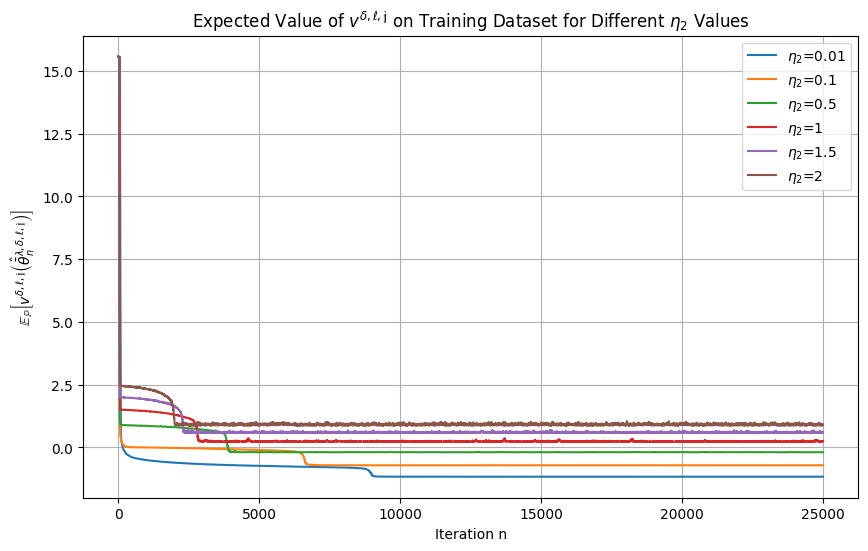

In [11]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Loop to plot each eta2 with error bars
for eta2 in eta2_values:
    plt.plot(range(n_iter), v_delta_results_dict[eta2], 
             label=f'$\eta_2$={eta2}')
    #plt.errorbar(range(n_iter), v_delta_results_dict[eta2], 
                 #yerr=std_v_delta_dict[eta2], 
                 #label=f'eta2={eta2}', 
                 #capsize=5, 
                 #marker='o')

# Adding labels and title
plt.title(r'Expected Value of $v^{\delta,\ell,\mathfrak{j}}$ on Training Dataset for Different $\eta_2$ Values')
plt.xlabel('Iteration n')
plt.ylabel(r'$\mathbb{E}_\mathbb{P}\left[v^{\delta,\ell,\mathfrak{j}}\left(\hat{\bar{\theta}}^{\lambda, \delta,\ell,\mathfrak{j}}_n\right)\right]$')
plt.legend()
plt.grid()
plt.savefig('sgld_robust_modifiedobj_traj.png')
plt.show()

In [ ]:
v_delta_test_results_dict = {eta2: np.zeros((n_iter,)) for eta2 in eta2_values}
std_v_delta_test_dict = {eta2: np.zeros((n_iter,)) for eta2 in eta2_values}

for eta2, theta_bar_histories in theta_bar_histories_dict.items():
    v_delta_test_array = np.zeros((n_runs, n_iter))
    
    for run in range(n_runs):
        # Define a function to compute v_delta for a single iteration using X_test
        def compute_v_delta_test(iteration):
            theta_bar = theta_bar_histories[run][iteration]
            return v_delta(theta_bar, X_test_minibatch, delta, eta1, eta2, p, U_NN, iota, discrete_space)

        # Create a tqdm progress bar and use the custom tqdm_joblib context manager
        with tqdm_joblib(tqdm(desc=f'Processing eta2={eta2}, run={run+1}/{n_runs}', total=n_iter, leave=False)) as progress_bar:
            v_delta_test_results = Parallel(n_jobs=-1)(
                delayed(compute_v_delta_test)(iteration) for iteration in range(n_iter)
            )
        
        # Store the results in the v_delta_test_array
        v_delta_test_array[run] = v_delta_test_results

    # Calculate the average and standard deviation for each iteration across all runs for X_test
    v_delta_test_results_dict[eta2] = np.mean(v_delta_test_array, axis=0)
    std_v_delta_test_dict[eta2] = np.std(v_delta_test_array, axis=0)

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Loop to plot each eta2 with error bars
for eta2 in eta2_values:
    plt.plot(range(n_iter), v_delta_test_results_dict[eta2], 
             label=f'$\eta_2$={eta2}')
    #plt.errorbar(range(n_iter), v_delta_results_dict[eta2], 
                 #yerr=std_v_delta_dict[eta2], 
                 #label=f'eta2={eta2}', 
                 #capsize=5, 
                 #marker='o')

# Adding labels and title
plt.title(r'Expected Value of $v^{\delta,\ell,\mathfrak{j}}$ on Test Dataset for Different $\eta_2$ Values')
plt.xlabel('Iteration n')
plt.ylabel(r'$\mathbb{E}_\mathbb{P}\left[v^{\delta,\ell,\mathfrak{j}}\left(\hat{\bar{\theta}}^{\lambda, \delta,\ell,\mathfrak{j}}_n\right)\right]$')
plt.legend()
plt.grid()
#plt.savefig('sgld_robust_modifiedobj_traj_test.png')
plt.show()

In [12]:
z_test = X_test[:, :-1]
y_test = X_test[:, -1]

# Compute reference loss using theta_0 with X_test
w_ref = theta_op[:-1]
b_ref = theta_op[-1]
reference_loss = np.zeros(n_iter)
for n in range(n_iter):
    ip_NN = np.dot(z_test, w_ref) + b_ref
    reference_loss[n] = np.mean(np.abs(y_test - 1 / (1 + np.exp(-ip_NN)))**2)

# Last value for reference
reference_loss_last = reference_loss[-1]
print(reference_loss_last)

0.005014


In [13]:
def sgld_es(n_iter, step, beta, theta_0, x_train, x_test, grad_U, reference_loss, **kwargs):  
    theta = theta_0
    theta_history = np.zeros((n_iter, theta_0.shape[0]))
    time_elapsed_eachiter = np.zeros(n_iter)
    
    Z = np.random.normal(size=(n_iter, theta_0.shape[0]))
    X_idx = np.random.choice(x_train.shape[0], size=n_iter)
    
    for n in range(n_iter):
        start_time = time.time()  
        
        theta = (theta +
                  np.sqrt(2 * step / beta) * Z[n] - 
                  step * grad_U(theta, x_train[X_idx[n]][None, :], **kwargs).ravel()
                 )
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        # Store the current theta and elapsed time
        theta_history[n] = theta
        time_elapsed_eachiter[n] = elapsed_time
    
    # Calculate losses and check for stopping condition
    losses = np.zeros(n_iter)
    for n in range(n_iter):
        w_mean = theta_history[n][:-1]
        b_mean = theta_history[n][-1]
        ip_NN = np.dot(x_test[:, :-1], w_mean) + b_mean  # Use x_test here
        losses[n] = np.mean(np.abs(x_test[:, -1] - 1 / (1 + np.exp(-ip_NN)))**2)

        if 0.99 * reference_loss < losses[n] < 1.01 * reference_loss:
            elapsed_time_es = np.sum(time_elapsed_eachiter[:n + 1]) 
            n_iter_es = n + 1
            return theta_history, time_elapsed_eachiter, elapsed_time_es, n_iter_es
    
    # If the stopping condition is never met
    elapsed_time_es = np.sum(time_elapsed_eachiter)  # Total time for all iterations
    n_iter_es = n_iter  # Total iterations
    
    return theta_history, time_elapsed_eachiter, elapsed_time_es, n_iter_es


def robust_sgld_es(n_iter, step, beta, theta_bar_0, x_train, x_test, delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, reference_loss, **kwargs):
    theta_bar = theta_bar_0
    theta_bar_history = np.zeros((n_iter, theta_bar_0.shape[0]))
    time_elapsed_eachiter = np.zeros(n_iter)
    
    Z = np.random.normal(size=(n_iter, theta_bar_0.shape[0]))
    X_idx = np.random.choice(x_train.shape[0], size=n_iter)
    
    for n in range(n_iter):
        start_time = time.time()
        
        theta_bar = (theta_bar +
            np.sqrt(2 * step / beta) * Z[n] - 
            step * grad_V_delta(theta_bar, x_train[X_idx[n]], delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs)
        )
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        # Store the current theta_bar and elapsed time
        theta_bar_history[n] = theta_bar
        time_elapsed_eachiter[n] = elapsed_time
    
    # Calculate losses and check for stopping condition
    losses = np.zeros(n_iter)
    for n in range(n_iter):
        w_mean = theta_bar_history[n][:-2]
        b_mean = theta_bar_history[n][-2] 
        ip_NN = np.dot(x_test[:, :-1], w_mean) + b_mean  # Use x_test here
        losses[n] = np.mean(np.abs(x_test[:, -1] - 1 / (1 + np.exp(-ip_NN)))**2)

        if 0.99 * reference_loss < losses[n] < 1.01 * reference_loss:
            elapsed_time_es = np.sum(time_elapsed_eachiter[:n + 1]) 
            n_iter_es = n + 1
            return theta_bar_history, time_elapsed_eachiter, elapsed_time_es, n_iter_es
            
    # Default values if stopping condition is never met
    elapsed_time_es = np.sum(time_elapsed_eachiter)  # Total time for all iterations
    n_iter_es = n_iter  # Total iterations
    return theta_bar_history, time_elapsed_eachiter, elapsed_time_es, n_iter_es

In [14]:
# Number of runs
n_runs = 100

# SGLD
results_sgld = Parallel(n_jobs=-1)(
    delayed(sgld_es)(
        n_iter=n_iter, 
        step=step, 
        beta=beta, 
        theta_0=theta_0, 
        x_train=X_train, 
        x_test=X_test, 
        grad_U=grad_U_NN, 
        reference_loss=reference_loss_last
    ) for _ in tqdm(range(n_runs), desc=f"Processing SGLD")
)

print(len(results_sgld[0]))
max_index_sgld = np.argmax([run[3] for run in results_sgld])  # Use index 3 for n_iter_es
max_iterations_sgld = results_sgld[max_index_sgld][3]
time_taken_sgld = results_sgld[max_index_sgld][2]  # Use index 2 for elapsed_time_es
theta_history_es = results_sgld[max_index_sgld][0]
average_time_taken_sgld = np.mean( [np.sum(run[1]) for run in results_sgld])
print(f"Maximum iterations for SGLD across all runs: {max_iterations_sgld}, Time taken: {time_taken_sgld:.2f} seconds, Average time taken: {average_time_taken_sgld:.2f} seconds")

Processing SGLD: 100% 100/100 [00:17<00:00,  5.63it/s]


4
Maximum iterations for SGLD across all runs: 25000, Time taken: 0.46 seconds, Average time taken: 0.45 seconds


In [15]:
theta_bar_history_es_dict = {}
index_dict = {}
iterations_dict = {}
for eta2 in eta2_values:
    results = Parallel(n_jobs=-1)(
        delayed(robust_sgld_es)(
            n_iter=n_iter,
            step=step,
            beta=beta,
            theta_bar_0=theta_bar_0,
            x_train=X_train,
            x_test=X_test,
            delta=delta,
            p=p,
            eta1=eta1,
            eta2=eta2,  # Use the current eta2_value
            U=U_NN,
            iota=iota,
            grad_U=grad_U_NN,
            grad_iota=grad_iota,
            discrete_space=discrete_space,
            reference_loss=reference_loss_last
        ) for _ in tqdm(range(n_runs), desc=f"Processing eta2={eta2}")
    )

    
    max_index = np.argmax([run[3] for run in results])
    index_dict[eta2] = max_index
    max_iterations_robust_sgld = results[max_index][3]
    iterations_dict[eta2] = max_iterations_robust_sgld
    time_taken_robust_sgld = results[max_index][2]
    theta_bar_history_es_dict[eta2] = results[max_index][0]
    average_time_taken_robust_sgld = np.mean([np.sum(run[1]) for run in results])
    print(f"eta2={eta2}: Maximum iterations: {max_iterations_robust_sgld}, Time taken: {time_taken_robust_sgld:.2f} seconds, Average time taken: {average_time_taken_robust_sgld:.2f} seconds")

Processing eta2=0.01: 100% 100/100 [22:36<00:00, 13.57s/it]


eta2=0.01: Maximum iterations: 25000, Time taken: 123.89 seconds, Average time taken: 122.73 seconds


Processing eta2=0.1: 100% 100/100 [21:18<00:00, 12.79s/it]


eta2=0.1: Maximum iterations: 25000, Time taken: 116.60 seconds, Average time taken: 116.54 seconds


Processing eta2=0.5: 100% 100/100 [20:53<00:00, 12.53s/it]


eta2=0.5: Maximum iterations: 20353, Time taken: 93.63 seconds, Average time taken: 114.80 seconds


Processing eta2=1: 100% 100/100 [20:50<00:00, 12.51s/it]


eta2=1: Maximum iterations: 4044, Time taken: 18.54 seconds, Average time taken: 114.28 seconds


Processing eta2=1.5: 100% 100/100 [20:45<00:00, 12.46s/it]


eta2=1.5: Maximum iterations: 2795, Time taken: 12.99 seconds, Average time taken: 113.99 seconds


Processing eta2=2: 100% 100/100 [20:45<00:00, 12.46s/it]


eta2=2: Maximum iterations: 2427, Time taken: 10.93 seconds, Average time taken: 113.85 seconds


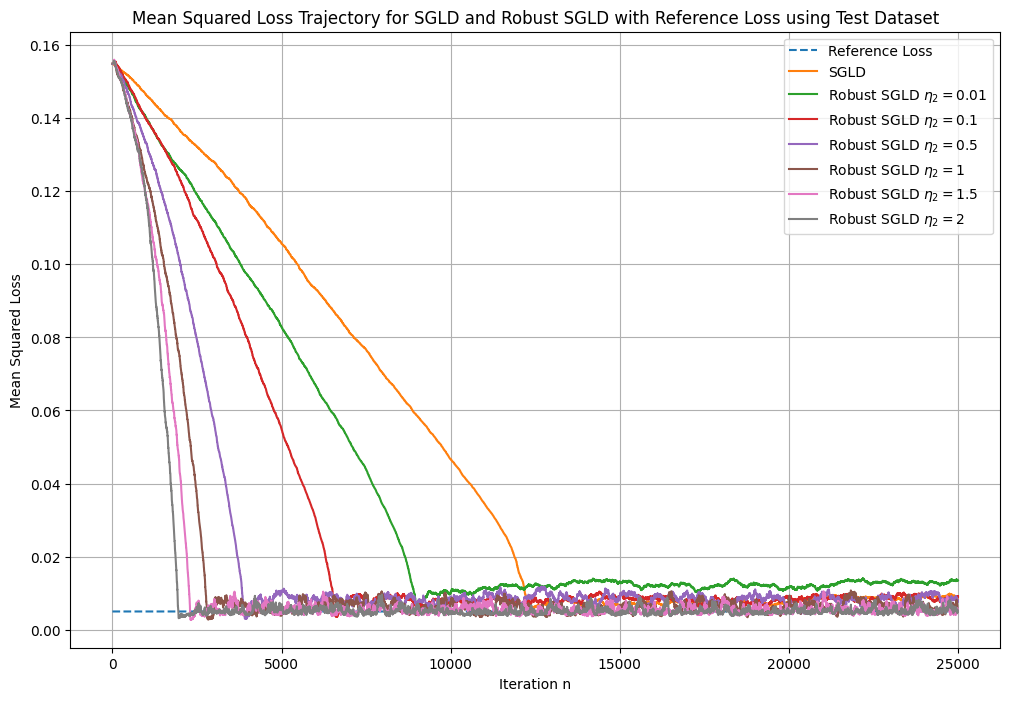

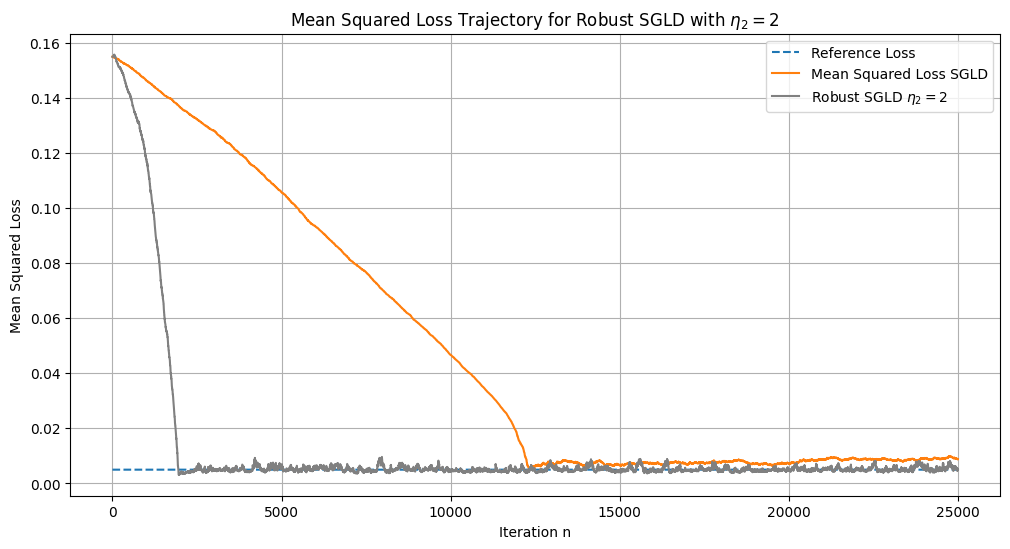

Closest loss to reference: 0.0052 at iteration 12378
Enforced loss details (using preset indices where applicable):
eta2=0.01: loss=0.005441 at iteration 9037
eta2=0.1: loss=0.004914 at iteration 6725
eta2=0.5: loss=0.005000 at iteration 20353
eta2=1: loss=0.005010 at iteration 4044
eta2=1.5: loss=0.004979 at iteration 2795
eta2=2: loss=0.005031 at iteration 2427


In [18]:
# Calculate loss for SGLD and SGLD_robust using X_test
w_sgld = theta_history_es[:,:-1]
b_sgld = theta_history_es[:,-1]
loss_sgld = np.zeros(n_iter)
for n in range(n_iter):
    ip_NN = np.dot(z_test, w_sgld[n]) + b_sgld[n]
    loss_sgld[n] = np.mean(np.abs(y_test - 1 / (1 + np.exp(-ip_NN)))**2)
diff_sgld = np.abs(loss_sgld - reference_loss_last)
closest_index_sgld = np.argmin(diff_sgld)
closest_loss_sgld = loss_sgld[closest_index_sgld]

closest_info = {}
# Initialize the main plot
plt.figure(figsize=(12, 8))

# Plot mean loss for SGLD and SGLD_robust
plt.plot(reference_loss, label='Reference Loss', linestyle='--')
plt.plot(loss_sgld, label='SGLD')

# Superimpose parameter trajectories for each eta2 value
for i, eta2 in enumerate(eta2_values):
    w_robust_eta2 = theta_bar_history_es_dict[eta2][:,:-2]
    b_robust_eta2 = theta_bar_history_es_dict[eta2][:,-2]
    
    # Calculate the loss trajectory for this eta2
    loss_trajectory_eta2 = np.zeros(n_iter)
    for n in range(n_iter):
        ip_NN = np.dot(z_test, w_robust_eta2[n]) + b_robust_eta2[n]
        loss_trajectory_eta2[n] = np.mean(np.abs(y_test - 1 / (1 + np.exp(-ip_NN)))**2)

    diff_eta2 = np.abs(loss_trajectory_eta2 - reference_loss_last)
    closest_index = np.argmin(diff_eta2)

    if iterations_dict[eta2] != 25000:
        preset_idx = np.array(iterations_dict[eta2])-1
        enforced_loss = loss_trajectory_eta2[preset_idx]
        enforced_iter = preset_idx+1
    else:
        enforced_loss = loss_trajectory_eta2[closest_index]
        enforced_iter = closest_index+1
    
    closest_info[eta2] = (enforced_loss, enforced_iter)
    
    # Plot the loss trajectory for this eta2
    plt.plot(loss_trajectory_eta2, label=r'Robust SGLD $\eta_2={}$'.format(eta2))

# Finalize the main plot
plt.title('Mean Squared Loss Trajectory for SGLD and Robust SGLD with Reference Loss using Test Dataset')
plt.xlabel('Iteration n')
plt.ylabel('Mean Squared Loss')
plt.legend()
plt.grid()

plt.savefig('sgld_robust_sgld_loss_traj1.png')
# Add a subplot for the specific eta2=2
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(reference_loss, label='Reference Loss', linestyle='--')
ax.plot(loss_sgld, label='Mean Squared Loss SGLD')

# Calculate and plot the loss trajectory for eta2=2
eta2 = eta2_values[-1]
w_robust_lsteta2 = theta_bar_history_es_dict[eta2][:,:-2]
b_robust_lsteta2 = theta_bar_history_es_dict[eta2][:,-2]

loss_trajectory_lsteta2 = np.zeros(n_iter)
for n in range(n_iter):
    ip_NN = np.dot(z_test, w_robust_lsteta2[n]) + b_robust_lsteta2[n]
    loss_trajectory_lsteta2[n] = np.mean(np.abs(y_test - 1 / (1 + np.exp(-ip_NN)))**2)

ax.plot(loss_trajectory_lsteta2, color='gray', label=r'Robust SGLD $\eta_2={}$'.format(eta2))

# Finalize the subplot
ax.set_title(r'Mean Squared Loss Trajectory for Robust SGLD with $\eta_2={}$'.format(eta2))
ax.set_xlabel('Iteration n')
ax.set_ylabel('Mean Squared Loss')
ax.legend()
ax.grid()

plt.savefig('sgld_robust_sgld_loss_traj2.png')
plt.show()

print(f"Closest loss to reference: {closest_loss_sgld:.4f} at iteration {closest_index_sgld}")
print("Enforced loss details (using preset indices where applicable):")
for eta2, (loss, iter) in closest_info.items():
    print(f"eta2={eta2}: loss={loss:.6f} at iteration {iter}")